In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()

# Test the Spark session
spark.range(5).show()


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [ ]:
file_path = "/content/drive/MyDrive/creditcard.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
from pyspark.sql.functions import col, count, isnan, when

# Counting both null and NaN values for each column
null_counts = [
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    for c in df.columns
]

# Display the count of null and NaN values for each column
df.select(null_counts).show()

# Optional: Calculate the total count of null and NaN values across all columns
total_nulls = sum(
    when(col(c).isNull() | isnan(col(c)), 1).otherwise(0)
    for c in df.columns
)
df.select(total_nulls.alias("Total_Null_or_NaN_Values")).show()


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+

+------------------------+
|Total_Null_or_NaN_Values|
+------------------------+
|                       0|
|                       0|
|                       0|
|                       0|
|                       0|
|                       0|
|                       0|
|                       0|
|                       0|
|              

In [ ]:
df.groupBy('Class').count().orderBy('count').show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



Over and down sampling

In [ ]:
fr_df = df.filter(col("Class") == 1)
nofr_df = df.filter(col("Class") == 0)
ratio = int(nofr_df.count()/fr_df.count())
print("ratio: {}".format(ratio))

ratio: 577


The non-fraudulent to fraudulent ratio is 577 to 1!

Oversampling

In [ ]:
# Duplicate the minority rows
oversampled_df = fr_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')

# Combine both oversampled minority rows and previous majority rows
df_o = nofr_df.union(oversampled_df)

# Display the first few rows of the resulting DataFrame
df_o.show()


+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

In [ ]:
print((df_o.count(), len(df_o.columns)))

(568199, 31)


Undersampling

In [ ]:
# Sample the majority class
sampled_majority_df = nofr_df.sample(False, 1/ratio)

# Combine the sampled majority class with the minority class
df_u = sampled_majority_df.union(fr_df)

# Display the first few rows of the resulting DataFrame
df_u.show()


+-------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+------------------+--------------------+-------------------+--------------------+------+-----+
|   Time|                V1|                 V2|                 V3|                V4|                 V5|                V6|                 V7|                 V8|                 V9|                V10|                 V11|                V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                V21|   

In [ ]:
print((df_u.count(), len(df_u.columns)))

(990, 31)


Learning Machines Spark's machine learning techniques require feature values to be in a vector. As a result, we will utilize VectorAssembler to convert all feature values to vectors.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
cols = df.columns
cols.remove('Time')
cols.remove('Class')

# We specify the object from the VectorAssembler class.
assembler = VectorAssembler(inputCols=cols, outputCol='features')

# Now we transform the data into vectors
data_o = assembler.transform(df_o)

data_o.select('features', 'Class').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
data_o = data_o.select('features', 'Class')
data_o.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[-1.3598071336738...|    0|
|[1.19185711131486...|    0|
|[-1.3583540615982...|    0|
|[-0.9662717115720...|    0|
|[-1.1582330934952...|    0|
|[-0.4259658844124...|    0|
|[1.22965763450793...|    0|
|[-0.6442694423481...|    0|
|[-0.8942860822028...|    0|
|[-0.3382617524257...|    0|
|[1.44904378114715...|    0|
|[0.38497821518095...|    0|
|[1.249998742053,-...|    0|
|[1.0693735878819,...|    0|
|[-2.7918547659339...|    0|
|[-0.7524170429566...|    0|
|[1.10321543528383...|    0|
|[-0.4369050713606...|    0|
|[-5.4012576631582...|    0|
|[1.4929359769862,...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
train_o, test_o = data_o.randomSplit([0.7,0.3])
train_o.show(5)
test_o.show(5)

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[-28.344757250015...|    0|
|[-27.670568881696...|    0|
|[-26.890567800461...|    0|
|[-24.743105349012...|    0|
|[-23.420358814350...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[-26.619952145208...|    0|
|[-24.465548667359...|    0|
|[-23.066841657925...|    0|
|[-22.382092095390...|    0|
|[-19.989586119202...|    0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
# We will do the same prep for undersampled dataframe. But in one box with no displays.

# Transform the data into vectors
data_u = assembler.transform(df_u)

data_u = data_u.select('features', 'Class')
train_u, test_u = data_u.randomSplit([0.7,0.3])

Scaling<br>
Before experimenting with various machine learning algorithms, we'd like to scale the data. Although the StandardScaler method might be employed, the Naive Bayes algorithm requires that no feature values be negative. As a result, we will scale the values between 0 and 1 using the MinMaxScaler function. We will use the same scaled dataset in all methods to make a more realistic comparison.

Finally, three different machine learning approaches will be used to compare the oversampled and undersampled datasets.a

In [ ]:
from pyspark.ml.feature import MinMaxScaler
minmax_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
data_o = minmax_scaler.fit(data_o).transform(data_o)
data_u = minmax_scaler.fit(data_u).transform(data_u)

In [ ]:
train_o, test_o = data_o.randomSplit([0.7,0.3])
train_u, test_u = data_u.randomSplit([0.7,0.3])

In [ ]:
print(train_o.show(5))
print(train_u.show(5))

+--------------------+-----+--------------------+
|            features|Class|     scaled_features|
+--------------------+-----+--------------------+
|[-28.344757250015...|    0|[0.47675143200430...|
|[-27.670568881696...|    0|[0.48820505799472...|
|[-26.890567800461...|    0|[0.50145631102189...|
|[-24.465548667359...|    0|[0.54265438484711...|
|[-23.383128541750...|    0|[0.56104336315908...|
+--------------------+-----+--------------------+
only showing top 5 rows

None
+--------------------+-----+--------------------+
|            features|Class|     scaled_features|
+--------------------+-----+--------------------+
|[-7.4248730000181...|    0|[0.70286888086370...|
|[-3.9163458748276...|    0|[0.80949665225807...|
|[-3.0732645706850...|    0|[0.83511876585655...|
|[-2.9855509266895...|    0|[0.83778447429955...|
|[-2.5092434992918...|    0|[0.85225995009603...|
+--------------------+-----+--------------------+
only showing top 5 rows

None


**Logistic Regression** <br>
Logistic Regression is a widely used statistical method for predicting binary outcomes. Its simplicity and interpretability make it a popular choice for binary classification problems. In this project, we have employed Logistic Regression to predict outcomes in a dataset characterized by class imbalance.

In [ ]:
logReg = LogisticRegression(labelCol='Class', featuresCol='scaled_features', maxIter=40)
model_o = logReg.fit(train_o)
model_u = logReg.fit(train_u)
predicted_test_o = model_o.transform(test_o)
predicted_test_u = model_u.transform(test_u)

In [ ]:
predicted_test_o.select('Class', 'prediction').show(10)
predicted_test_u.select('Class', 'prediction').show(10)

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
+-----+----------+
only showing top 10 rows

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
+-----+----------+
only showing top 10 rows



**Results** <br>
The performance of the Logistic Regression models was evaluated using several metrics, including accuracy, weighted precision, weighted recall, and the F1 score. These metrics provided insights into how well the models performed on both oversampled and undersampled datasets.

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
accuracy_LR_o = evaluator.evaluate(predicted_test_o)
accuracy_LR_u = evaluator.evaluate(predicted_test_u)
evaluator.setMetricName("weightedPrecision")
weightedPrecision_LR_o = evaluator.evaluate(predicted_test_o)
weightedPrecision_LR_u = evaluator.evaluate(predicted_test_u)
evaluator.setMetricName("weightedRecall")
weightedRecall_LR_o = evaluator.evaluate(predicted_test_o)
weightedRecall_LR_u = evaluator.evaluate(predicted_test_u)
print(f'Logistic Regression - Oversampled Data:\n'
      f'  Accuracy:          {accuracy_LR_o:.4f}\n'
      f'  Weighted Precision:{weightedPrecision_LR_o:.4f}\n'
      f'  Weighted Recall:   {weightedRecall_LR_o:.4f}\n')

print(f'Logistic Regression - Undersampled Data:\n'
      f'  Accuracy:          {accuracy_LR_u:.4f}\n'
      f'  Weighted Precision:{weightedPrecision_LR_u:.4f}\n'
      f'  Weighted Recall:   {weightedRecall_LR_u:.4f}\n')



Logistic Regression - Oversampled Data:
  Accuracy:          0.9476
  Weighted Precision:0.9492
  Weighted Recall:   0.9476

Logistic Regression - Undersampled Data:
  Accuracy:          0.9502
  Weighted Precision:0.9502
  Weighted Recall:   0.9502



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming you have Logistic Regression model predictions: predicted_test_o and predicted_test_u

# Initialize the evaluator for the F1 metric
evaluator_LR_f1 = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='f1')

# Evaluate F1 Score for the oversampled dataset
f1_score_LR_o = evaluator_LR_f1.evaluate(predicted_test_o)

# Evaluate F1 Score for the undersampled dataset
f1_score_LR_u = evaluator_LR_f1.evaluate(predicted_test_u)

# Print results
print('Logistic Regression - F1 Score Oversampled:', f1_score_LR_o)
print('Logistic Regression - F1 Score Undersampled:', f1_score_LR_u)


Logistic Regression - F1 Score Oversampled: 0.9475451649199828
Logistic Regression - F1 Score Undersampled: 0.9501639124208701


**Random Forest Classifier** <br>
Random Forest is an ensemble learning method known for its high accuracy, ability to run on large datasets, and capability to handle numerous input variables without variable deletion. It operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes of the individual trees.

In [ ]:
random_forest_classifier = RandomForestClassifier(labelCol='Class', featuresCol='scaled_features', numTrees=40)
model_o = random_forest_classifier.fit(train_o)
model_u = random_forest_classifier.fit(train_u)


predicted_test_rf_o = model_o.transform(test_o)
predicted_test_rf_u = model_u.transform(test_u)

predicted_test_rf_o.select('Class', 'prediction').show(10)
predicted_test_rf_u.select('Class', 'prediction').show(10)

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
+-----+----------+
only showing top 10 rows



**Results and Discussion**<br>
The performance evaluation revealed how the Random Forest Classifier responded to the class imbalance problem in different scenarios. By comparing its performance on the oversampled versus the undersampled dataset, we were able to gauge the impact of these techniques on the classifier's ability to generalize and make accurate predictions

In [ ]:
evaluator_rf = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
accuracy_rf_o = evaluator_rf.evaluate(predicted_test_rf_o)
accuracy_rf_u = evaluator_rf.evaluate(predicted_test_rf_u)
evaluator_rf.setMetricName("weightedPrecision")
weightedPrecision_rf_o = evaluator_rf.evaluate(predicted_test_rf_o)
weightedPrecision_rf_u = evaluator_rf.evaluate(predicted_test_rf_u)
evaluator_rf.setMetricName("weightedRecall")
weightedRecall_rf_o = evaluator_rf.evaluate(predicted_test_rf_o)
weightedRecall_rf_u = evaluator_rf.evaluate(predicted_test_rf_u)
print(f'Random Forest - Oversampled Data:\n'
      f'  Accuracy:          {accuracy_rf_o:.4f}\n'
      f'  Weighted Precision: {weightedPrecision_rf_o:.4f}\n'
      f'  Weighted Recall:    {weightedRecall_rf_o:.4f}\n')

print(f'Random Forest - Undersampled Data:\n'
      f'  Accuracy:          {accuracy_rf_u:.4f}\n'
      f'  Weighted Precision: {weightedPrecision_rf_u:.4f}\n'
      f'  Weighted Recall:    {weightedRecall_rf_u:.4f}\n')




Random Forest - Oversampled Data:
  Accuracy:          0.9497
  Weighted Precision: 0.9534
  Weighted Recall:    0.9497

Random Forest - Undersampled Data:
  Accuracy:          0.9402
  Weighted Precision: 0.9422
  Weighted Recall:    0.9402



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Initialize the evaluator for the F1 metric
evaluator_rf_f1 = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='f1')

# Evaluate F1 Score for the oversampled dataset
f1_score_rf_o = evaluator_rf_f1.evaluate(predicted_test_rf_o)

# Evaluate F1 Score for the undersampled dataset
f1_score_rf_u = evaluator_rf_f1.evaluate(predicted_test_rf_u)

# Print results
print('Random Forest - F1 Score Oversampled:', f1_score_rf_o)
print('Random Forest - F1 Score Undersampled:', f1_score_rf_u)


Random Forest - F1 Score Oversampled: 0.9495501464804479
Random Forest - F1 Score Undersampled: 0.9401531074525854


**Naive Bayes**<br>
Naive Bayes is a simple yet effective probabilistic classifier based on applying Bayes' theorem with strong (naive) independence assumptions between the features. It is particularly known for its simplicity, efficiency, and good performance in a wide range of problem settings, including text classification and medical diagnosis.

In [ ]:
naive_bayes = NaiveBayes(featuresCol='scaled_features', labelCol='Class', smoothing=1.0)

In [ ]:
model_o = naive_bayes.fit(train_o)
model_u = naive_bayes.fit(train_u)
predicted_test_nb_o = model_o.transform(test_o)
predicted_test_nb_u = model_u.transform(test_u)

In [ ]:
predicted_test_nb_o.select('Class', 'prediction').show(10)
predicted_test_nb_u.select('Class', 'prediction').show(10)

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



**Results and Discussion**<br>
We examined the effectiveness of the Naive Bayes classifier in handling class imbalance by evaluating its performance on the oversampled and undersampled datasets. The results were analyzed through various metrics, providing insights into the model's ability to generalize and accurately predict outcomes in both scenarios.

In [ ]:
evaluator_nb = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
accuracy_NB_o = evaluator_nb.evaluate(predicted_test_nb_o)
accuracy_NB_u = evaluator_nb.evaluate(predicted_test_nb_u)
evaluator_nb.setMetricName("weightedPrecision")
weightedPrecision_NB_o = evaluator_nb.evaluate(predicted_test_nb_o)
weightedPrecision_NB_u = evaluator_nb.evaluate(predicted_test_nb_u)

evaluator_nb.setMetricName("weightedRecall")
weightedRecall_NB_o = evaluator_nb.evaluate(predicted_test_nb_o)
weightedRecall_NB_u = evaluator_nb.evaluate(predicted_test_nb_u)

print(f'Naive Bayes - Oversampled Data:\n'
      f'  Accuracy:          {accuracy_NB_o:.4f}\n'
      f'  Weighted Precision: {weightedPrecision_NB_o:.4f}\n'
      f'  Weighted Recall:    {weightedRecall_NB_o:.4f}\n')

print(f'Naive Bayes - Undersampled Data:\n'
      f'  Accuracy:          {accuracy_NB_u:.4f}\n'
      f'  Weighted Precision: {weightedPrecision_NB_u:.4f}\n'
      f'  Weighted Recall:    {weightedRecall_NB_u:.4f}\n')


Naive Bayes - Oversampled Data:
  Accuracy:          0.8856
  Weighted Precision: 0.9066
  Weighted Recall:    0.8856

Naive Bayes - Undersampled Data:
  Accuracy:          0.8837
  Weighted Precision: 0.9058
  Weighted Recall:    0.8837



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Existing code for fitting the model and predictions
naive_bayes = NaiveBayes(featuresCol='scaled_features', labelCol='Class', smoothing=1.0)
model_o = naive_bayes.fit(train_o)
model_u = naive_bayes.fit(train_u)
predicted_test_nb_o = model_o.transform(test_o)
predicted_test_nb_u = model_u.transform(test_u)

# Use MulticlassClassificationEvaluator with 'f1' metric
evaluator_nb_f1 = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='f1')

# Evaluate F1 score
f1_score_NB_o = evaluator_nb_f1.evaluate(predicted_test_nb_o)
f1_score_NB_u = evaluator_nb_f1.evaluate(predicted_test_nb_u)

# Print results
print('F1 Score Oversampled =', f1_score_NB_o)
print('F1 Score Undersampled =', f1_score_NB_u)

F1 Score Oversampled = 0.8840213231102623
F1 Score Undersampled = 0.8822670686593914


**Gradient Boosting Classifier**<br>
Gradient Boosting is an ensemble learning technique that builds and combines multiple weak models (typically decision trees) to create a robust predictive model. It's particularly known for its effectiveness in handling various types of data, including imbalanced datasets.

In [ ]:
gradient_boost_class = GBTClassifier(labelCol='Class', featuresCol='scaled_features')
model_o = gradient_boost_class.fit(train_o)
model_u = gradient_boost_class.fit(train_u)

predicted_test_gbc_o = model_o.transform(test_o)
predicted_test_gbc_u = model_u.transform(test_u)

predicted_test_gbc_o.select('Class', 'prediction').show(10)
predicted_test_gbc_u.select('Class', 'prediction').show(10)

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       1.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
+-----+----------+
only showing top 10 rows



**Results and Discussion**<br>
The evaluation metrics provided insights into the efficacy of the Gradient Boosting Classifier under different class distributions. The analysis focused on:

1) The accuracy of the model in correctly predicting outcomes.<br>
2) The precision and recall, giving us an understanding of the model's ability to identify the minority class correctly.<br>
3) The F1 score, which combines precision and recall into a single metric, offering a balanced view of the model's performance.<br>

In [ ]:
evaluator_gbc = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
accuracy_gbc_o = evaluator_gbc.evaluate(predicted_test_gbc_o)
accuracy_gbc_u = evaluator_gbc.evaluate(predicted_test_gbc_u)
evaluator_gbc.setMetricName("weightedPrecision")
weightedPrecision_gbc_o = evaluator_gbc.evaluate(predicted_test_gbc_o)
weightedPrecision_gbc_u = evaluator_gbc.evaluate(predicted_test_gbc_u)
evaluator_gbc.setMetricName("weightedRecall")
weightedRecall_gbc_o = evaluator_gbc.evaluate(predicted_test_gbc_o)
weightedRecall_gbc_u = evaluator_gbc.evaluate(predicted_test_gbc_u)

print(f'Gradient Boosted Classifier - Oversampled Data:\n'
      f'  Accuracy:          {accuracy_gbc_o:.4f}\n'
      f'  Weighted Precision: {weightedPrecision_gbc_o:.4f}\n'
      f'  Weighted Recall:    {weightedRecall_gbc_o:.4f}\n')

print(f'Gradient Boosted Classifier - Undersampled Data:\n'
      f'  Accuracy:          {accuracy_gbc_u:.4f}\n'
      f'  Weighted Precision: {weightedPrecision_gbc_u:.4f}\n'
      f'  Weighted Recall:    {weightedRecall_gbc_u:.4f}\n')


Gradient Boosted Classifier - Oversampled Data:
  Accuracy:          0.9811
  Weighted Precision: 0.9812
  Weighted Recall:    0.9811

Gradient Boosted Classifier - Undersampled Data:
  Accuracy:          0.9269
  Weighted Precision: 0.9269
  Weighted Recall:    0.9269



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



# Initialize the evaluator for the F1 metric
evaluator_gbc_f1 = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='f1')

# Evaluate F1 Score for the oversampled dataset
f1_score_gbc_o = evaluator_gbc_f1.evaluate(predicted_test_gbc_o)

# Evaluate F1 Score for the undersampled dataset
f1_score_gbc_u = evaluator_gbc_f1.evaluate(predicted_test_gbc_u)

# Print results
print('Gradient Boosted Classifier - F1 Score Oversampled:', f1_score_gbc_o)
print('Gradient Boosted Classifier - F1 Score Undersampled:', f1_score_gbc_u)


Gradient Boosted Classifier - F1 Score Oversampled: 0.9811447054202407
Gradient Boosted Classifier - F1 Score Undersampled: 0.9269102990033222


**Dataset Overview for Fraud Detection**<br>
This PySpark script efficiently analyzes a financial transaction dataset, summarizing key aspects crucial for fraud detection. It computes the total number of transactions, features, and the proportion of normal versus fraudulent activities. These insights are vital for understanding dataset characteristics, especially the class imbalance critical in modeling fraud detection algorithms.

In [ ]:
from pyspark.sql.functions import col

# Total number of transactions
total_transactions = df.count()

# Total number of columns
total_columns = len(df.columns)

# Total number of features (assuming the last column is the label)
total_features = total_columns - 1

# Total number of label(s)
total_labels = 1

# Total number of normal transactions
total_normal_transactions = df.filter(col('Class') == 0).count()

# Total number of fraudulent transactions
total_fraudulent_transactions = df.filter(col('Class') == 1).count()

# Percentage of fraudulent transactions
percentage_fraudulent = (total_fraudulent_transactions / total_transactions) * 100

# Percentage of normal transactions
percentage_normal = (total_normal_transactions / total_transactions) * 100

# Print the results
print("Total number of transactions:", total_transactions)
print("Total number of columns:", total_columns)
print("Total number of features:", total_features)
print("Total number of label(s):", total_labels)
print("Total number of normal transactions:", total_normal_transactions)
print("Total number of fraudulent transactions:", total_fraudulent_transactions)
print("Percentage of fraudulent transactions: {:.4f}%".format(percentage_fraudulent))
print("Percentage of normal transactions: {:.4f}%".format(percentage_normal))

Total number of transactions: 284807
Total number of columns: 31
Total number of features: 30
Total number of label(s): 1
Total number of normal transactions: 284315
Total number of fraudulent transactions: 492
Percentage of fraudulent transactions: 0.1727%
Percentage of normal transactions: 99.8273%


In [ ]:
from tabulate import tabulate

# Headers for the table
headers = ["Model", "Data Type", "Accuracy", "Weighted Precision", "Weighted Recall", "F1 Score"]

# Data for the table
data = [
    ["Naive Bayes", "Oversampled", accuracy_NB_o, weightedPrecision_NB_o, weightedRecall_NB_o, f1_score_NB_o],
    ["Naive Bayes", "Undersampled", accuracy_NB_u, weightedPrecision_NB_u, weightedRecall_NB_u, f1_score_NB_u],
    ["Gradient Boosted", "Oversampled", accuracy_gbc_o, weightedPrecision_gbc_o, weightedRecall_gbc_o, f1_score_gbc_o],
    ["Gradient Boosted", "Undersampled", accuracy_gbc_u, weightedPrecision_gbc_u, weightedRecall_gbc_u, f1_score_gbc_u],
    ["Random Forest", "Oversampled", accuracy_rf_o, weightedPrecision_rf_o, weightedRecall_rf_o, f1_score_rf_o],
    ["Random Forest", "Undersampled", accuracy_rf_u, weightedPrecision_rf_u, weightedRecall_rf_u, f1_score_rf_u],
    ["Logistic Regression", "Oversampled", accuracy_LR_o, weightedPrecision_LR_o, weightedRecall_LR_o, f1_score_LR_o],
    ["Logistic Regression", "Undersampled", accuracy_LR_u, weightedPrecision_LR_u, weightedRecall_LR_u, f1_score_LR_u]
]

# Print the table
print(tabulate(data, headers=headers))


Model                Data Type       Accuracy    Weighted Precision    Weighted Recall    F1 Score
-------------------  ------------  ----------  --------------------  -----------------  ----------
Naive Bayes          Oversampled     0.885584              0.906643           0.885584    0.884021
Naive Bayes          Undersampled    0.883721              0.905839           0.883721    0.882267
Gradient Boosted     Oversampled     0.981145              0.981152           0.981145    0.981145
Gradient Boosted     Undersampled    0.92691               0.92691            0.92691     0.92691
Random Forest        Oversampled     0.949665              0.953432           0.949665    0.94955
Random Forest        Undersampled    0.940199              0.942189           0.940199    0.940153
Logistic Regression  Oversampled     0.947598              0.949175           0.947598    0.947545
Logistic Regression  Undersampled    0.950166              0.950183           0.950166    0.950164


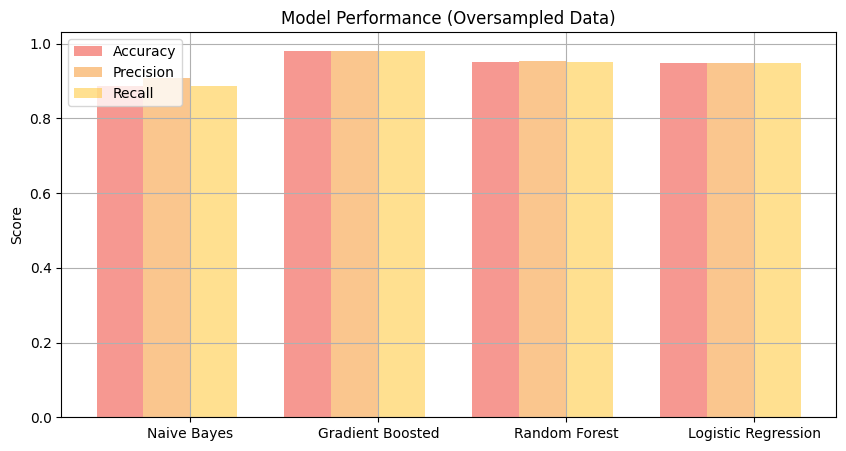

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
models = ['Naive Bayes', 'Gradient Boosted', 'Random Forest', 'Logistic Regression']
accuracy_oversampled = [accuracy_NB_o, accuracy_gbc_o, accuracy_rf_o, accuracy_LR_o]
precision_oversampled = [weightedPrecision_NB_o, weightedPrecision_gbc_o, weightedPrecision_rf_o, weightedPrecision_LR_o]
recall_oversampled = [weightedRecall_NB_o, weightedRecall_gbc_o, weightedRecall_rf_o, weightedRecall_LR_o]

# Setting the positions and width for the bars
pos = list(range(len(models)))
width = 0.25

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 5))

# Create a bar with accuracy data,
# in position pos,
plt.bar(pos,
        accuracy_oversampled,
        width,
        alpha=0.5,
        color='#EE3224',
        label=models[0])

# Create a bar with precision data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],
        precision_oversampled,
        width,
        alpha=0.5,
        color='#F78F1E',
        label=models[1])

# Create a bar with recall data,
# in position pos + width buffer,
plt.bar([p + width*2 for p in pos],
        recall_oversampled,
        width,
        alpha=0.5,
        color='#FFC222',
        label=models[2])

# Set the y axis label
ax.set_ylabel('Score')

# Set the chart's title
ax.set_title('Model Performance (Oversampled Data)')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(models)

# Adding the legend and showing the plot
plt.legend(['Accuracy', 'Precision', 'Recall'], loc='upper left')
plt.grid()
plt.show()


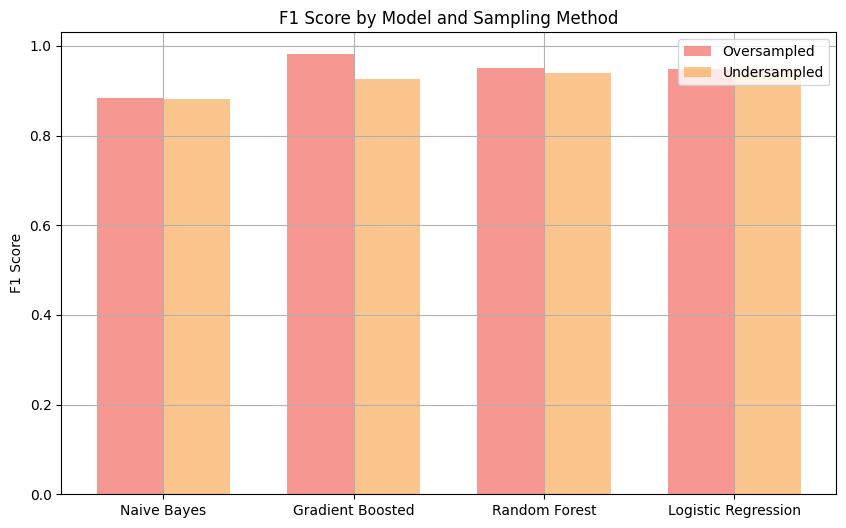

In [ ]:
import matplotlib.pyplot as plt

# Example model names
models = ['Naive Bayes', 'Gradient Boosted', 'Random Forest', 'Logistic Regression']

# Example F1 scores for each model (replace with your actual scores)
f1_scores_oversampled = [f1_score_NB_o, f1_score_gbc_o, f1_score_rf_o, f1_score_LR_o] # Replace with your F1 scores for oversampled
f1_scores_undersampled = [f1_score_NB_u, f1_score_gbc_u, f1_score_rf_u, f1_score_LR_u] # Replace with your F1 scores for undersampled

# Setting the positions for the bars
pos = list(range(len(models)))
width = 0.35  # Width of a bar

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar([p - width/2 for p in pos],
        f1_scores_oversampled,
        width,
        alpha=0.5,
        color='#EE3224',
        label='Oversampled')

plt.bar([p + width/2 for p in pos],
        f1_scores_undersampled,
        width,
        alpha=0.5,
        color='#F78F1E',
        label='Undersampled')

# Setting axis labels, title, and ticks
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Model and Sampling Method')
ax.set_xticks(pos)
ax.set_xticklabels(models)

# Adding the legend and showing the plot
plt.legend(['Oversampled', 'Undersampled'], loc='upper right')
plt.grid()
plt.show()
